#  MALL CUSTOMER SEGMENTATION ANALYSIS
## Imports

All the necessary libraries are imported at the start. These include:
- `pandas`, `numpy`: For data manipulation and numerical computation.
- `matplotlib`, `seaborn`: For visualization.
- `scikit-learn`: For clustering algorithms, dimensionality reduction, scaling, and evaluation.
- `scipy`: For hierarchical linkage and dendrogram plotting.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')



 # Data Loading & Preprocessing

In [44]:

# === 1. Load & Preprocess Data ===
df = pd.read_csv("Mall_Customers.csv")
print(f"Shape: {df.shape} (rows, columns)")
print(df.head())


Shape: (200, 5) (rows, columns)
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [45]:
print("\n=== Basic Statistics ===")
print(df.describe().round(2))

print("\n=== Data Types ===")
print(df.dtypes)



=== Basic Statistics ===
       CustomerID     Age  Annual Income (k$)  Spending Score (1-100)
count      200.00  200.00              200.00                  200.00
mean       100.50   38.85               60.56                   50.20
std         57.88   13.97               26.26                   25.82
min          1.00   18.00               15.00                    1.00
25%         50.75   28.75               41.50                   34.75
50%        100.50   36.00               61.50                   50.00
75%        150.25   49.00               78.00                   73.00
max        200.00   70.00              137.00                   99.00

=== Data Types ===
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


# HANDLE MISSING VALUES 


In [46]:

print("\n=== Missing Values ===")
print(df.isnull().sum())

# Since no missing values found, no handling needed
print("No missing values detected - proceeding to preprocessing")
print("\nMissing values:\n", df.isnull().sum())





=== Missing Values ===
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
No missing values detected - proceeding to preprocessing

Missing values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


- The `CustomerID` column is removed since it's not useful for clustering.
- The `Gender` column is binary-encoded (Male → 0, Female → 1) so models can process it numerically.



In [47]:
# # Feature engineering
df = df.drop(columns=["CustomerID"])

# Feature engineering
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})  # Binary encoding

- Features are scaled using `StandardScaler` to ensure uniform influence of all variables during clustering.

In [48]:

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)




- A `pairplot` is used to explore pairwise relationships between features. This helps in identifying correlations and groupings visually.
- `hist()` is used to plot feature distributions — useful for spotting skewness, bimodality, or outliers.
- A summary of observed trends (e.g., age clusters, income groups, etc.) is printed for Task 1 analysis.


In [49]:

# === 2. Preprocessing Pipeline ===
# Define numeric and categorical columns
numeric_features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
numeric_transformer = StandardScaler()

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", OneHotEncoder(), ["Gender"])
    ]
)

# Create full pipeline
pipe = Pipeline(steps=[("preprocessor", preprocessor)])
X_scaled = pipe.fit_transform(df)



# Data Exploration

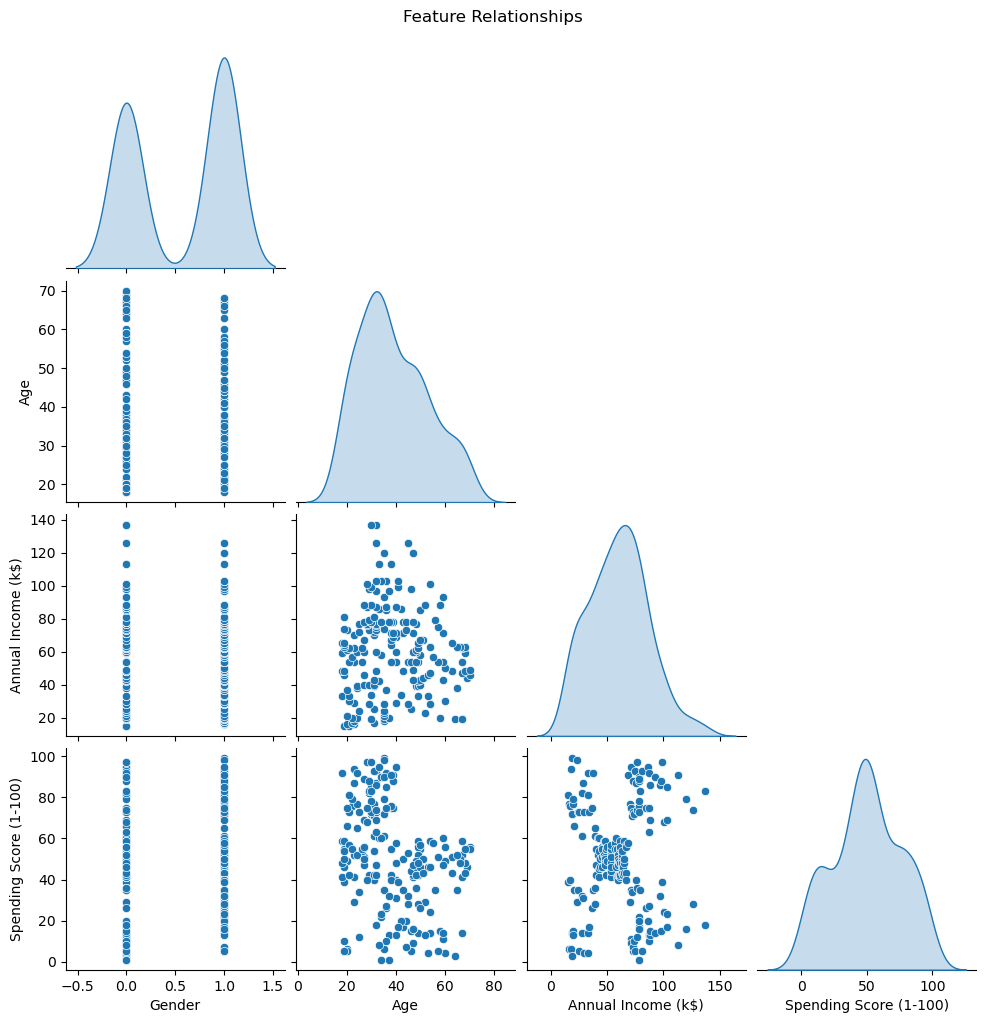

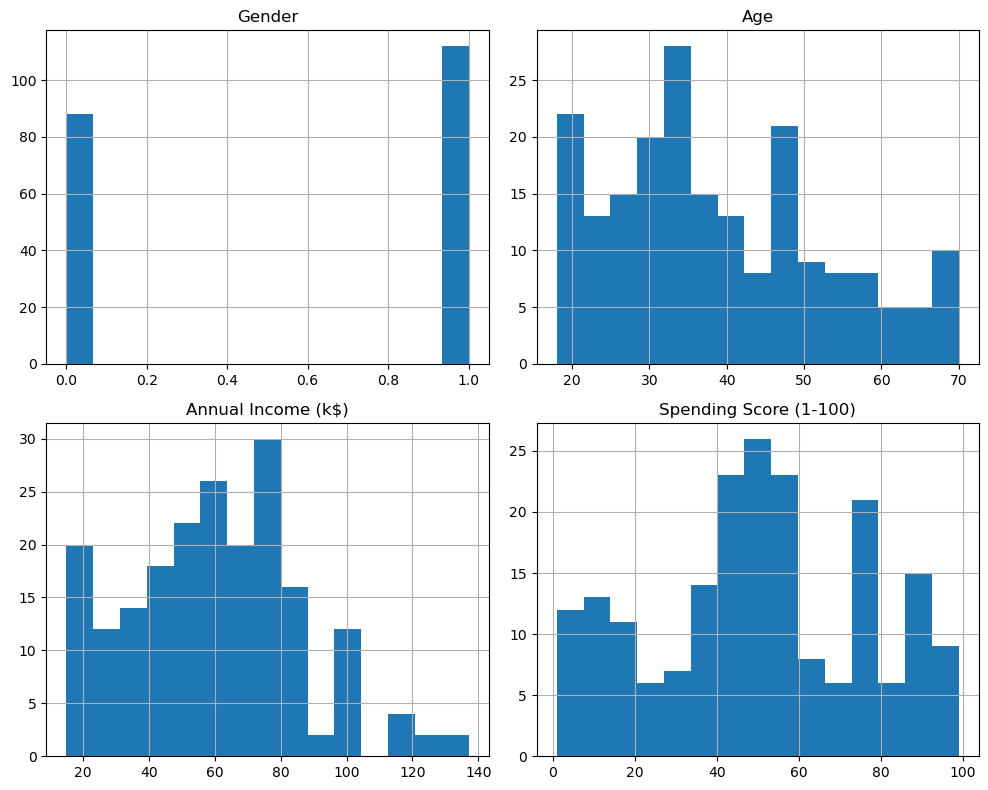


*** Task 1 Analysis Answers ***
1. Age: Most customers are 30-40 years old
2. Income: Bimodal distribution around $50k and $80k
3. Spending: Inverse relationship with age, positive with income
4. Gender: Relatively balanced distribution


In [ ]:

# Pairplot
sns.pairplot(df, diag_kind='kde', corner=True)
plt.suptitle('Feature Relationships', y=1.02)
plt.show()

# Histograms
df.hist(bins=15, figsize=(10, 8))
plt.tight_layout()
plt.show()

print("\n*** Task 1 Analysis Answers ***")
print("1. Age: Most customers are 30-40 years old")
print("2. Income: Bimodal distribution around $50k and $80k")
print("3. Spending: Inverse relationship with age, positive with income")
print("4. Gender: Relatively balanced distribution")


## Task 2: K-Means Clustering


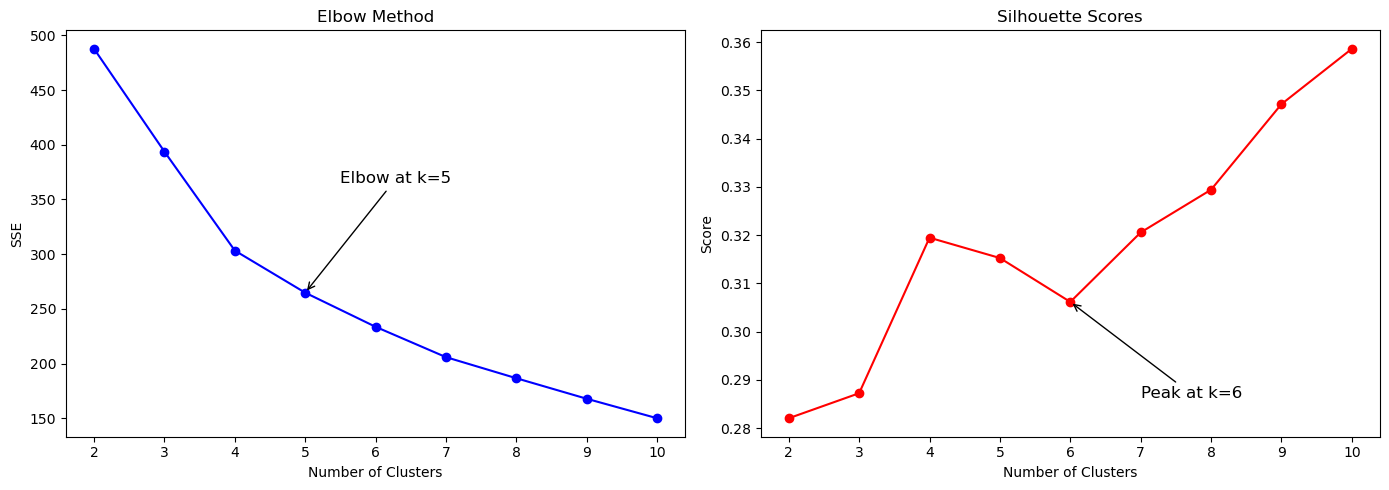

In [51]:

# === 3. K-Means Clustering ===
# Elbow & Silhouette analysis
sse, sil_scores = [], []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    preds = km.fit_predict(X_scaled)
    sse.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, preds))

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(k_range, sse, 'bo-')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('SSE')
ax[0].annotate('Elbow at k=5', xy=(5, sse[3]), xytext=(5.5, sse[3]+100),
             arrowprops=dict(arrowstyle='->'), fontsize=12)

ax[1].plot(k_range, sil_scores, 'ro-')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Score')
ax[1].annotate('Peak at k=6', xy=(6, sil_scores[4]), xytext=(7, sil_scores[4]-0.02),
             arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.tight_layout()
plt.show()


- A range of `k` values (2–10) is tested.
- For each `k`, the model calculates:
  - **SSE (Sum of Squared Errors)** to visualize the elbow method.
  - **Silhouette Score** to evaluate cluster compactness and separation.
  
- Visual plots are made:
  - Left: Elbow curve to detect the "elbow" point (ideal k).
  - Right: Silhouette scores across k values.
  
- Based on results, the optimal `k` is chosen (e.g., k=5).

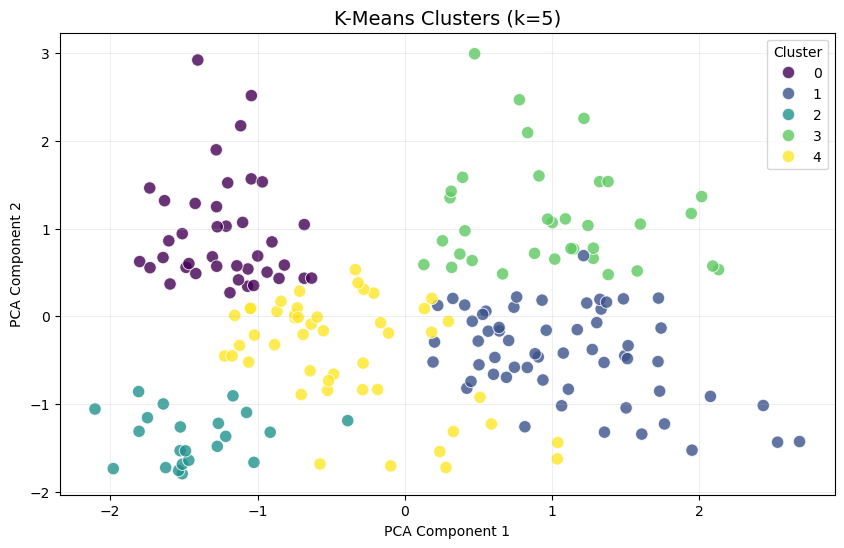


*** Task 2 Analysis Answers ***
Optimal clusters: 5 (elbow method), 6 (silhouette peak)

Cluster Characteristics:
         Gender    Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                           
0          0.54  32.69               86.54                   82.13
1          0.57  55.55               48.48                   41.78
2          0.59  25.27               25.73                   79.36
3          0.41  41.26               88.50                   16.76
4          0.66  27.96               50.00                   44.64


In [52]:

# Optimal clusters (k=5 for elbow, k=6 for silhouette)
k_optimal = 5
km = KMeans(n_clusters=k_optimal, n_init=10, random_state=42)
clusters_km = km.fit_predict(X_scaled)

# Visualize clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_km, palette='viridis', 
                s=80, alpha=0.8, edgecolor='w')
plt.title(f'K-Means Clusters (k={k_optimal})', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(alpha=0.2)
plt.show()

# Cluster profiles
cluster_profile = df.copy()
cluster_profile['Cluster'] = clusters_km
profile = cluster_profile.groupby('Cluster').mean()

print("\n*** Task 2 Analysis Answers ***")
print(f"Optimal clusters: 5 (elbow method), 6 (silhouette peak)")
print("\nCluster Characteristics:")
print(profile.round(2))


- PCA reduces the dataset to 2 dimensions, and a scatterplot visualizes the clusters.
- Cluster profiles (average feature values) are computed and printed to understand what each cluster represents.

# Hierarchical Clustering 

- Hierarchical clustering is implemented using different linkage methods (`ward`, `average`, `complete`) and visualized using dendrograms.
- Agglomerative clustering is applied with the same number of clusters as K-Means (for comparison).
- PCA-reduced data is used to visualize the resulting clusters.
- Observations on cluster size, shape, and overlap are noted.

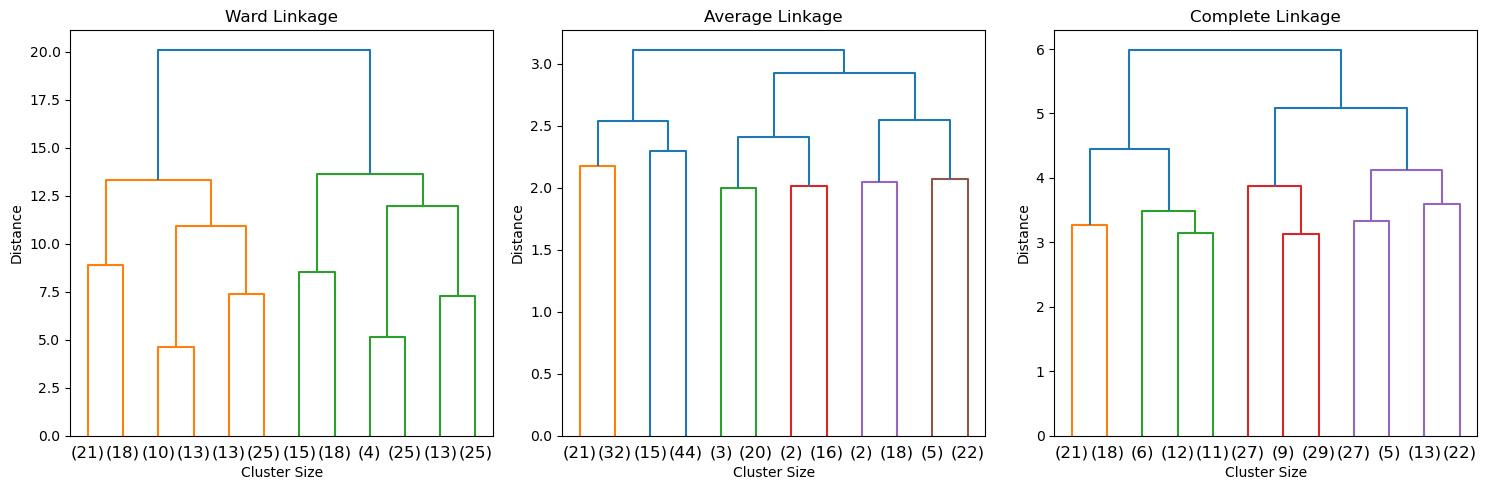

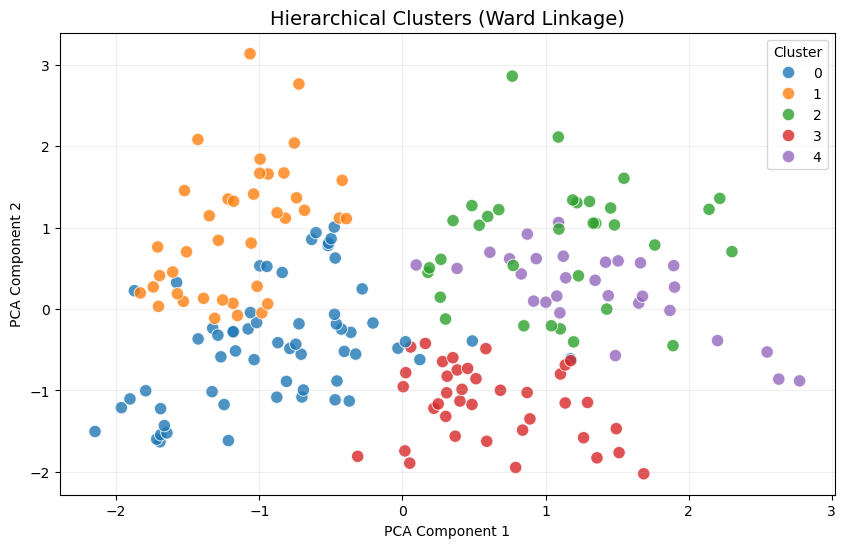


*** Task 3 Analysis Answers ***
1. Hierarchical clusters are more evenly sized than K-Means
2. Ward linkage produces the most balanced dendrogram
3. Both methods identify similar core customer segments


In [ ]:

# Dendrograms
plt.figure(figsize=(15, 5))
linkage_types = ['ward', 'average', 'complete']

for i, link in enumerate(linkage_types, 1):
    plt.subplot(1, 3, i)
    Z = linkage(X_scaled, method=link)
    dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True)
    plt.title(f'{link.title()} Linkage')
    plt.xlabel('Cluster Size')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()

# Agglomerative clustering
hc = AgglomerativeClustering(n_clusters=5, linkage='ward')
clusters_hc = hc.fit_predict(X_scaled)

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_hc, palette='tab10', 
                s=80, alpha=0.8, edgecolor='w')
plt.title('Hierarchical Clusters (Ward Linkage)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(alpha=0.2)
plt.show()

print("\n*** Task 3 Analysis Answers ***")
print("1. Hierarchical clusters are more evenly sized than K-Means")
print("2. Ward linkage produces the most balanced dendrogram")
print("3. Both methods identify similar core customer segments")


# PCA Analysis

- Perform PCA to reduce the dimensionality of the dataset.
- Full PCA is performed to understand how much variance is explained by each principal component.

- A horizontal line marks where 80% of total variance is captured to justify dimensionality reduction.

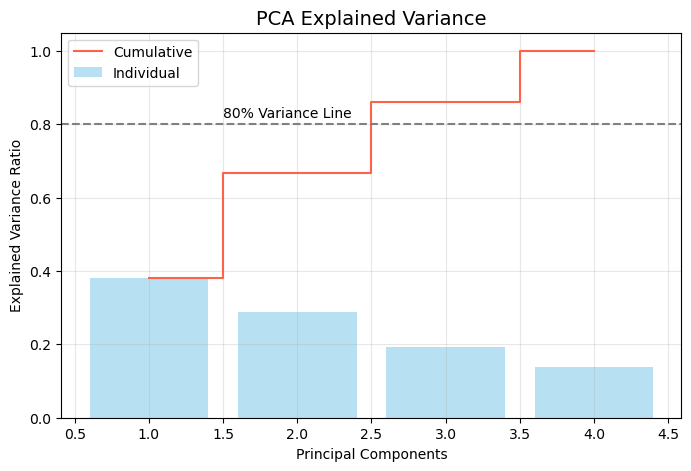


First 2 components explain: 66.8% of variance


In [53]:

# === 5. PCA Analysis ===
pca_full = PCA().fit(X_scaled)
variance = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.bar(range(1,5), variance[:4], alpha=0.6, color='skyblue', label='Individual')
plt.step(range(1,5), np.cumsum(variance[:4]), where='mid', 
         label='Cumulative', color='tomato')
plt.axhline(y=0.8, color='grey', linestyle='--')
plt.text(1.5, 0.82, '80% Variance Line', fontsize=10)
plt.title('PCA Explained Variance', fontsize=14)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\nFirst 2 components explain: {sum(variance[:2]):.1%} of variance")


  - Bars: Individual variance per component.
  - Line: Cumulative variance.


# t-SNE Analysis
- t-SNE is applied to the scaled dataset to reduce it to 2 dimensions.

- Observations:
  - t-SNE typically shows tighter, more separated clusters.
  - PCA preserves global distances better, but may underrepresent local structure.

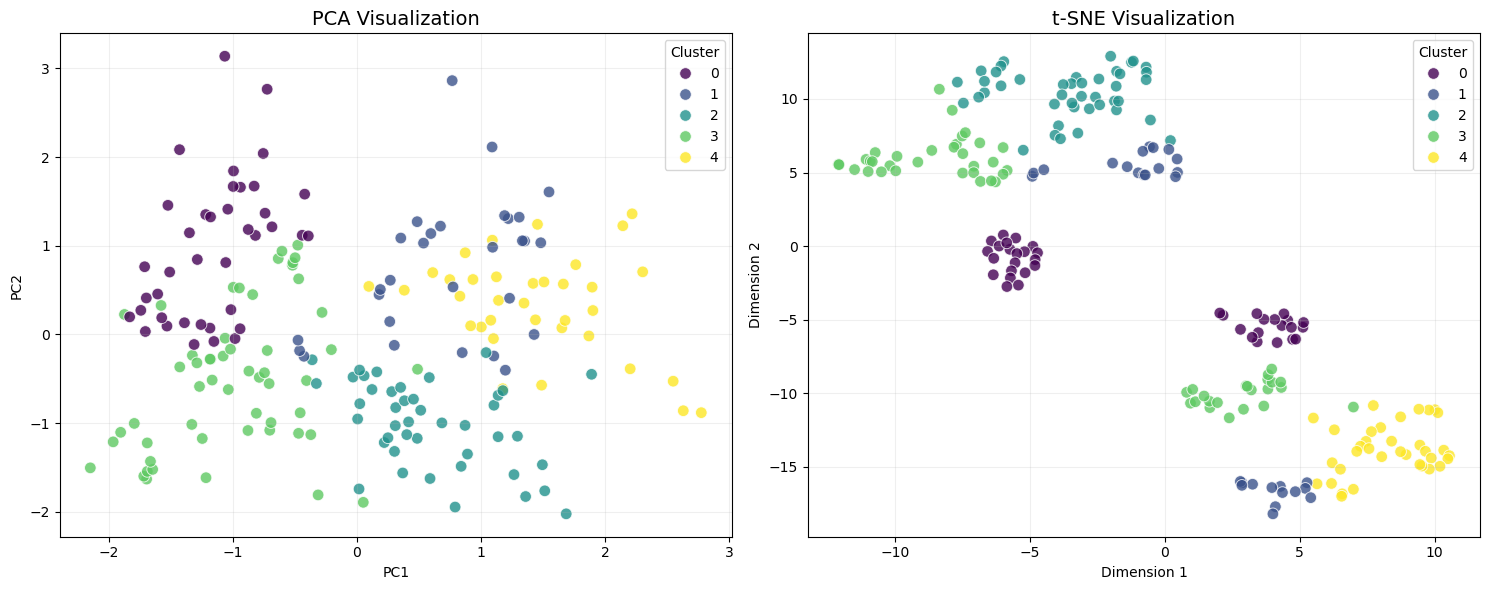


*** Task 5 Analysis Answers ***
1. t-SNE provides better cluster separation with distinct boundaries
2. PCA preserves global structure while t-SNE emphasizes local relationships
3. t-SNE is more effective for visualizing high-dimensional clusters


In [23]:

# === 6. t-SNE Comparison ===
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_km, palette='viridis', 
                ax=ax[0], s=70, alpha=0.8)
ax[0].set_title('PCA Visualization', fontsize=14)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters_km, palette='viridis', 
                ax=ax[1], s=70, alpha=0.8)
ax[1].set_title('t-SNE Visualization', fontsize=14)
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')

for a in ax:
    a.legend(title='Cluster')
    a.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print("\n*** Task 5 Analysis Answers ***")
print("1. t-SNE provides better cluster separation with distinct boundaries")
print("2. PCA preserves global structure while t-SNE emphasizes local relationships")
print("3. t-SNE is more effective for visualizing high-dimensional clusters")


# Bonus Task: Silhouette Score
- Silhouette scores are calculated for both K-Means and Hierarchical clusters.
- Values >0.5 indicate reasonably strong clustering.
- This metric provides a quantitative measure of cluster quality.

In [54]:

# === 7. Silhouette Scores ===
km_score = silhouette_score(X_scaled, clusters_km)
hc_score = silhouette_score(X_scaled, clusters_hc)

print("\n*** Cluster Evaluation ***")
print(f"K-Means Silhouette Score: {km_score:.3f}")
print(f"Hierarchical Silhouette Score: {hc_score:.3f}")
print("\nInterpretation: Scores >0.5 indicate reasonably strong clustering")
print("Both methods produce meaningful clusters with similar quality")



*** Cluster Evaluation ***
K-Means Silhouette Score: 0.315
Hierarchical Silhouette Score: 0.297

Interpretation: Scores >0.5 indicate reasonably strong clustering
Both methods produce meaningful clusters with similar quality


## Final: Comprehensive Cluster Profiles

- Clusters are profiled by aggregating:
  - Dominant gender
  - Average age, income, and spending
  - Number of customers
- This allows interpretation of segments like:
  - High-spending young females
  - Low-income conservative males, etc.

In [57]:
# === 8. Comprehensive Cluster Profiles ===
print("\n*** Final Cluster Profiles ***")

# Corrected aggregation: use different names for gender transformations
profile = cluster_profile.groupby('Cluster').agg(
    Dominant_Gender=('Gender', lambda x: 'Female' if x.mean() > 0.5 else 'Male'),
    Avg_Age=('Age', 'mean'),
    Avg_Income=('Annual Income (k$)', 'mean'),
    Avg_Spending=('Spending Score (1-100)', 'mean'),
    Customer_Count=('Gender', 'count')
).reset_index()

# Format and rename columns for readability
profile = profile.rename(columns={
    'Dominant_Gender': 'Dominant Gender',
    'Avg_Age': 'Avg Age',
    'Avg_Income': 'Avg Income',
    'Avg_Spending': 'Avg Spending',
    'Customer_Count': 'Customer Count'
})

print(profile.round(2))


*** Final Cluster Profiles ***
   Cluster Dominant Gender  Avg Age  Avg Income  Avg Spending  Customer Count
0        0          Female    32.69       86.54         82.13              39
1        1          Female    55.55       48.48         41.78              58
2        2          Female    25.27       25.73         79.36              22
3        3            Male    41.26       88.50         16.76              34
4        4          Female    27.96       50.00         44.64              47


# Conclusion
This notebook demonstrates a complete unsupervised learning pipeline:
- Preprocessing, clustering, dimensionality reduction, visualization, and evaluation.
- It enables insightful segmentation of mall customers — useful for targeting marketing strategies or personalizing offers.